# Authors: Nazmi Bunjaku (2775692), Geri Bakushi (2819369)
# CIS 492 - Big Data Analytics
# Professor Sunnie Chung
# Final Project - IMDB Sentiment Analysis
# May 05, 2023

##### Import necessary packages/libraries

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re, string, unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import os
print(os.listdir("../IMDB Sentiment Analysis/input"))
import warnings
warnings.filterwarnings('ignore')

['.DS_Store', 'IMDB Dataset.csv']


### Load training dataset

In [21]:
df = pd.read_csv("input/IMDB Dataset.csv")
print(df.shape)
df.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### Explanatory Data Analysis (EDA)

In [22]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


## Sentiment Analysis Count

In [23]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

### Text Normalization

In [24]:
# Tokenization of text
text_tokenizer = ToktokTokenizer()

# Setting English stopwords
ENG_stopwords = nltk.corpus.stopwords.words('english')

### Split the training dataset

In [25]:
# Training data
train_reviews = df.review[:40000]
train_sentiments = df.sentiment[:40000]

# Testing data
test_reviews = df.review[40000:]
test_sentiments = df.sentiment[40000:]

print(train_reviews.shape, train_sentiments.shape)
print(test_reviews.shape, test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


### Removing HTML strips and text noise

In [26]:
# Removal of HTML strips
def remove_html_strip(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing square brackets
def remove_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing text noise
def remove_noise(text):
    de_text = remove_html_strip(text)
    de_text = remove_square_brackets(text)
    return de_text

# Call function on "review" column
df['review'] = df['review'].apply(remove_noise)
print(df['review'])

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object


### Removing Stopwords

In [27]:
iden_stop = set(stopwords.words('english'))

def remove_stopwords(text, is_lower_case=False):
    token_key = text_tokenizer.tokenize(text)
    token_key = [i.strip() for i in token_key]
    if is_lower_case:
        filtered_tokens = [i for i in token_key if i not in ENG_stopwords]
    else:
        filtered_tokens = [i for i in token_key if i.lower() not in ENG_stopwords]
    post_tokenizer = ' '.join(filtered_tokens)
    return post_tokenizer

df['review'] = df['review'].apply(remove_stopwords)

### Remove special characters

In [28]:
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    patternized_text = re.sub(pattern, '', text)
    return patternized_text

# Apply function on "review" column
df['review'] = df['review'].apply(remove_special_characters)
print(df['review'])

0        One reviewers mentioned watching 1 Oz episode ...
1        wonderful little production br  br  The filmin...
2        thought wonderful way spend time hot summer we...
3        Basically  family little boy  Jake  thinks  zo...
4        Petter Mattei   Love Time Money  visually stun...
                               ...                        
49995    thought movie right good job  creative origina...
49996    Bad plot  bad dialogue  bad acting  idiotic di...
49997    Catholic taught parochial elementary schools n...
49998     going disagree previous comment side Maltin o...
49999    one expects Star Trek movies high art  fans ex...
Name: review, Length: 50000, dtype: object


### Text Stemmatization

In [29]:
def apply_stemmatization(text):
    porter_stemmer = nltk.porter.PorterStemmer()
    stemmed_text = ' '.join([porter_stemmer.stem(word) for word in text.split()])
    return stemmed_text

df['review'] = df['review'].apply(apply_stemmatization)

### Normalize Training Reviews

In [30]:
norm_train_reviews = df.review[:40000]
norm_train_reviews[0]

'one review mention watch 1 oz episod hook right exactli happen mebr br the first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordbr br it call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far awaybr br i would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that g

### Normalize Test Reviews

In [31]:
norm_test_reviews = df.review[40000:]
norm_test_reviews[45005]

'read review watch piec cinemat garbag took least 2 page find somebodi els think appallingli unfunni montag acm humour 70 inde era least funni set sketch comedi ever seen till come along half skit alreadi done infinit better act monti python woodi allen say nice piec anim last 90 second highlight film would still get close sum mindless drivelridden wast 75 minut is semin comedi world semin realli mean semen scatolog humour world scat actual fece precursor joke mean handbook comedi tit bum odd beaver nice pubesc boy least one hand free found playboy exist give break earli 70 way sketch comedi go back least ten year prior way could even forgiv film even made gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 lower score recommend insomniac coma patient perhap peopl suffer lockjaw jaw would final drop open disbelief'

## Term Frequency-Inverse Document Frequency model (TFIDF)

In [32]:
#TFIDF Vectorizerbb
tfidf_vector = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1,3))

# Transformed Training Reviews
tfidf_vector_train_reviews = tfidf_vector.fit_transform(norm_train_reviews)

# Transformed Test Reviews
tfidf_vector_test_reviews = tfidf_vector.transform(norm_test_reviews)

print('TFIDF_TRAIN: ', tfidf_vector_train_reviews.shape)
print('TFIDF_TEST: ', tfidf_vector_test_reviews.shape)

TFIDF_TRAIN:  (40000, 6028806)
TFIDF_TEST:  (10000, 6028806)


## Bag of Words (BoW)

In [33]:
# Initialize Count Vectorizer
bow_vector = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1,3))

# Transform train reviews
bow_vector_train_reviews = bow_vector.fit_transform(norm_train_reviews)

# Transform test reviews
bow_vector_test_reviews = bow_vector.transform(norm_test_reviews)

print('BoW_cv_TRAIN: ', bow_vector_train_reviews.shape)
print('BoW_cv_TEST: ', bow_vector_train_reviews.shape)

BoW_cv_TRAIN:  (40000, 6028806)
BoW_cv_TEST:  (40000, 6028806)


### Labeling the sentiment analysis text

In [34]:
labeler = LabelBinarizer()

# Transformed Sentiment Data
labeled_transformed_sentiment_data = labeler.fit_transform(df['sentiment'])
print(labeled_transformed_sentiment_data.shape)

(50000, 1)


### Split the sentiment Data

In [35]:
train_sentiment_data = labeled_transformed_sentiment_data[:40000]
test_sentiment_data = labeled_transformed_sentiment_data[40000:]

print(train_sentiment_data)
print(test_sentiment_data)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


## Stochastic Gradient Descent or Linear Support Vector Machines for BoW and TFIDF Features

In [36]:
# Training the linear svm
linear_svm_model = SGDClassifier(loss='hinge', max_iter=500, random_state=42)

# Fitting the SVM for BoW
svm_bow = linear_svm_model.fit(bow_vector_train_reviews, train_sentiment_data)
print(svm_bow)

# Fitting the SVM for TFIDF
svm_tfidf = linear_svm_model.fit(tfidf_vector_train_reviews, train_sentiment_data)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


##### Evaluate Model Perfomance on Test Data

In [37]:
# Predicting the model for BoW
svm_bow_predict = linear_svm_model.predict(bow_vector_test_reviews)
print('SVM BoW Score: ', svm_bow_predict)

# Predicting the model for TFIDF
svm_tfidf_predict = linear_svm_model.predict(tfidf_vector_test_reviews)
print('SVM TFIDF Score: ', svm_tfidf_predict)

SVM BoW Score:  [1 1 1 ... 1 1 1]
SVM TFIDF Score:  [1 1 1 ... 1 1 1]


##### Accuracy of the Model on Test Data

In [38]:
#Accuracy score for bag of words
svm_bow_accuracy=accuracy_score(test_sentiment_data, svm_bow_predict)
print("svm_accuracy :",svm_bow_accuracy)
#Accuracy score for tfidf features
svm_tfidf_accuracy=accuracy_score(test_sentiment_data, svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_accuracy)

svm_accuracy : 0.581
svm_tfidf_score : 0.5112


##### Output the classification report

In [39]:
# BoW
svm_bow_report = classification_report(test_sentiment_data, svm_bow_predict, target_names=['Positive', 'Negative'])
print(svm_bow_report)

# TFIDF
svm_tfidf_report = classification_report(test_sentiment_data, svm_tfidf_predict, target_names=['Positive', 'Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.93      0.17      0.29      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000

              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



##### Confusion Matrix

In [40]:
# BoW
bow_confusion_matrix = confusion_matrix(test_sentiment_data, svm_bow_predict, labels=[1,0])
print(bow_confusion_matrix)

# TFIDF
tfidf_confusion_matrix = confusion_matrix(test_sentiment_data, svm_tfidf_predict, labels=[1,0])
print(tfidf_confusion_matrix)

[[4947   60]
 [4130  863]]
[[5007    0]
 [4888  105]]


## Logistic Regression

In [41]:
# Training the model
logistic_regression_model = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)

# Fitting the model for Bag of Words
logistic_regression_bow = logistic_regression_model.fit(bow_vector_train_reviews, train_sentiment_data)
print(logistic_regression_bow)

# Fitting the model for TFIDF Features
logistic_regression_tfidf = logistic_regression_model.fit(tfidf_vector_train_reviews, train_sentiment_data)
print(logistic_regression_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


##### Perform Logistic Regression on test Dataset

In [42]:
# Predicting the model for BoW
lr_bow_predict = logistic_regression_model.predict(bow_vector_test_reviews)
print(lr_bow_predict)

# Predicting the model for TFIDF
lr_tfidf_predict = logistic_regression_model.predict(tfidf_vector_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]


##### Accuracy of the model

In [43]:
# Accuracy score for the BoW model
lr_bow_accuracy = accuracy_score(test_sentiment_data, lr_bow_predict)
print('Logistic Regression - Bag of Words Accuracy: ', lr_bow_accuracy)

lr_tfidf_accuracy = accuracy_score(test_sentiment_data, lr_tfidf_predict)
print('Logistic Regression - TDIDF Accuracy: ', lr_tfidf_accuracy)

Logistic Regression - Bag of Words Accuracy:  0.7444
Logistic Regression - TDIDF Accuracy:  0.7437


##### Output the Classification Report

In [44]:
# Classification Report for BoW
lr_bow_report = classification_report(test_sentiment_data, lr_bow_predict, target_names=['Positive', 'Negative'])
print(lr_bow_report)

# Classification Report for TFIDF
lr_tfidf_report = classification_report(test_sentiment_data, lr_tfidf_predict, target_names=['Positive', 'Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.74      0.74      4993
    Negative       0.74      0.75      0.75      5007

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

              precision    recall  f1-score   support

    Positive       0.74      0.76      0.75      4993
    Negative       0.75      0.73      0.74      5007

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



##### Confusion Matrix

In [45]:
# BoW
bow_confusion_matrix = confusion_matrix(test_sentiment_data, lr_bow_predict, labels=[1,0])
print(bow_confusion_matrix)

tfidf_confusion_matrix = confusion_matrix(test_sentiment_data, lr_tfidf_predict, labels=[1,0])
print(tfidf_confusion_matrix)

[[3761 1246]
 [1310 3683]]
[[3664 1343]
 [1220 3773]]


## Multinomial Bayes for BoW & TFIDF features

In [46]:
# Training the model
MNB_model = MultinomialNB()
# Fitting the SVM for BoW
MNB_BoW = MNB_model.fit(bow_vector_train_reviews, train_sentiment_data)
print(MNB_BoW)
# Fitting the SVM for TFIDF
MNB_TFIDF = MNB_model.fit(tfidf_vector_train_reviews, train_sentiment_data)
print(MNB_TFIDF)

MultinomialNB()
MultinomialNB()


##### Model Performance on Test Data

In [47]:
# Predicting the model for BoW
MNB_BoW_predict = MNB_model.predict(bow_vector_test_reviews)
print(MNB_BoW_predict)

# Predicting the model for TFIDF
MNB_TFIDF_predict = MNB_model.predict(tfidf_vector_test_reviews)
print(MNB_TFIDF_predict)

[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]


##### Accuracy of the Model

In [48]:
# Accuracy for MNB_model BoW
MNB_BoW_score = accuracy_score(test_sentiment_data, MNB_BoW_predict)
print('MNB_BoW_score: ', MNB_BoW_score)

# Accuracy for MNB_model TFIDF
MNB_TFIDF_score = accuracy_score(test_sentiment_data, MNB_TFIDF_predict)
print('MNB_TFIDF_score: ', MNB_TFIDF_score)

MNB_BoW_score:  0.7442
MNB_TFIDF_score:  0.7447


##### Classification Report

In [49]:
# BoW
MNB_BoW_report = classification_report(test_sentiment_data, MNB_BoW_predict, target_names = ['Positive', 'Negative'])
print(MNB_BoW_report)

# TFIDF
MNB_TFIDF_report = classification_report(test_sentiment_data, MNB_TFIDF_predict, target_names = ['Positive', 'Negative'])
print(MNB_TFIDF_report)

              precision    recall  f1-score   support

    Positive       0.74      0.74      0.74      4993
    Negative       0.74      0.74      0.74      5007

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

              precision    recall  f1-score   support

    Positive       0.74      0.75      0.74      4993
    Negative       0.75      0.74      0.74      5007

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [50]:
# Confusion Matrix for BoW
bow_confusion_matrix = confusion_matrix(test_sentiment_data, MNB_BoW_predict, labels=[1,0])
print(bow_confusion_matrix)

# Confusion Matrix for TFIDF
tfidf_confusion_matrix = confusion_matrix(test_sentiment_data, MNB_TFIDF_predict, labels=[1,0])
print(tfidf_confusion_matrix)

[[3727 1280]
 [1278 3715]]
[[3723 1284]
 [1269 3724]]


## WordCloud for Negative Reviews

<function matplotlib.pyplot.show(close=None, block=None)>

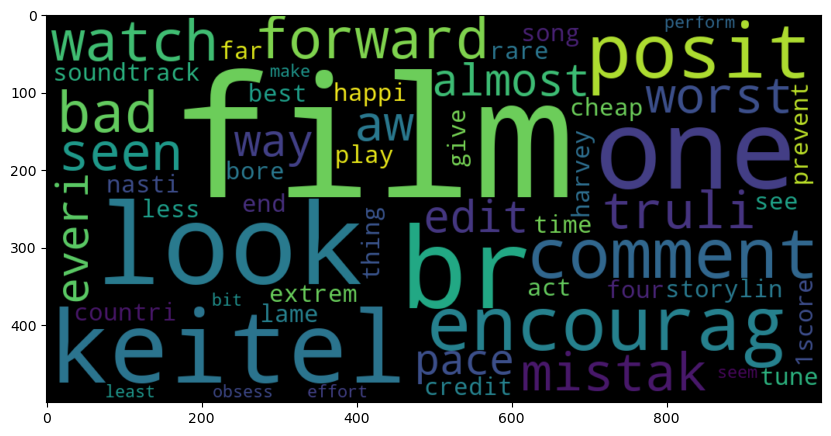

In [51]:
# WordCloud for Negative Reviews
plt.figure(figsize=(10,10))
negative_text = norm_train_reviews[8]
word_cloud = WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=word_cloud.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

## WordCloud for Positive Reviews

<function matplotlib.pyplot.show(close=None, block=None)>

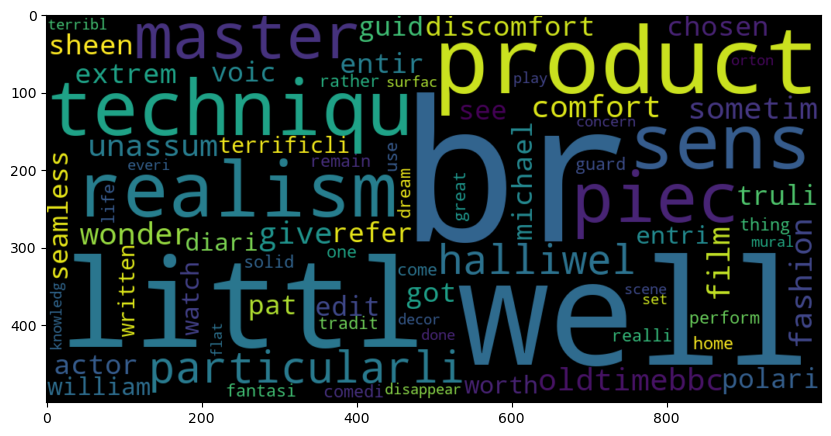

In [52]:
plt.figure(figsize=(10,10))
positive_text = norm_train_reviews[1]
word_cloud = WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=word_cloud.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show